## Imports

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
from sklearn.metrics import classification_report
import numpy as np

c:\Users\asus\anaconda3\envs\complaint_nlp_v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data load and cleaning

In [4]:
## Load dataset
df = pd.read_csv('data/complaints.csv')
print(df.columns)

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788940 entries, 0 to 9788939
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

In [8]:
# Filter rows with non-null complaint text using exact column name
df = df[df['Consumer complaint narrative'].notnull()]

# Select relevant columns and rename
dataset_df = df[['Consumer complaint narrative', 'Product']].rename(
    columns={'Consumer complaint narrative': 'text', 'Product': 'category'}
)

print(dataset_df.head())

                                                 text  \
2   usc section 1681 states that there must be wri...   
4   PNC Bank will not allow me to link my accounts...   
7   Ally Financial has not reported to the credit ...   
12  In my initial letter dated XX/XX/2019, to Hyun...   
13  I am the consumer natural person making this r...   

                                             category  
2   Credit reporting, credit repair services, or o...  
4                         Checking or savings account  
7   Credit reporting, credit repair services, or o...  
12                                    Debt collection  
13                                    Debt collection  


In [11]:
dataset_df = dataset_df.reset_index(drop=True)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021026 entries, 0 to 3021025
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   text      object
 1   category  object
dtypes: object(2)
memory usage: 46.1+ MB


In [12]:
## Encode labels
labels = dataset_df['category'].unique()
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

dataset_df['label'] = dataset_df['category'].map(label2id)

print(label2id)

{'Credit reporting, credit repair services, or other personal consumer reports': 0, 'Checking or savings account': 1, 'Debt collection': 2, 'Mortgage': 3, 'Payday loan, title loan, or personal loan': 4, 'Credit reporting or other personal consumer reports': 5, 'Credit card or prepaid card': 6, 'Credit card': 7, 'Student loan': 8, 'Money transfer, virtual currency, or money service': 9, 'Vehicle loan or lease': 10, 'Bank account or service': 11, 'Credit reporting': 12, 'Prepaid card': 13, 'Payday loan, title loan, personal loan, or advance loan': 14, 'Debt or credit management': 15, 'Consumer Loan': 16, 'Money transfers': 17, 'Payday loan': 18, 'Other financial service': 19, 'Virtual currency': 20}


In [17]:
import pandas as pd

# First, drop duplicate texts to ensure uniqueness before sampling
dataset_df_nodup = dataset_df.drop_duplicates(subset=['text']).reset_index(drop=True)

# Define total desired samples
total_samples = 100000

# Calculate number of categories
num_categories = dataset_df_nodup['category'].nunique()

# Calculate samples per category
samples_per_category = total_samples // num_categories

# Group by category and sample
balanced_sample_df = dataset_df_nodup.groupby('category').apply(
    lambda x: x.sample(
        n=samples_per_category if len(x) >= samples_per_category else len(x),
        random_state=42
    )
).reset_index(drop=True)

# Check distribution
print(balanced_sample_df['category'].value_counts())
print("Total samples:", len(balanced_sample_df))

# Save directly
balanced_sample_df.to_csv('data/samples_data.csv', index=False)


C:\Users\asus\AppData\Local\Temp\ipykernel_10500\457394110.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_sample_df = dataset_df_nodup.groupby('category').apply(


category
Bank account or service                                                         4761
Checking or savings account                                                     4761
Consumer Loan                                                                   4761
Credit card                                                                     4761
Credit card or prepaid card                                                     4761
Credit reporting                                                                4761
Credit reporting or other personal consumer reports                             4761
Credit reporting, credit repair services, or other personal consumer reports    4761
Debt collection                                                                 4761
Money transfer, virtual currency, or money service                              4761
Mortgage                                                                        4761
Payday loan, title loan, or personal loan               

In [18]:
# Check full duplicate rows (both text and label identical)
duplicates = balanced_sample_df.duplicated()
print("Total duplicate rows (entire row):", duplicates.sum())


Total duplicate rows (entire row): 0


In [19]:
## Convert to Dataset
from datasets import Dataset

dataset = Dataset.from_pandas(balanced_sample_df[['text', 'label']])

In [20]:
## Tokenization

from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Define tokenization function
def tokenize_function(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Check one sample to verify tokenization
print(dataset[0])

Map: 100%|██████████| 82705/82705 [00:23<00:00, 3583.87 examples/s]

{'label': tensor(11), 'input_ids': tensor([  101,  1052, 12273,  8169,  5145,  2109, 21068,  9887,  2058,  8013,
         2326,  7026,  2578,  1999,  2344,  2000, 28616, 19738,  2094,  2033,
         2046,  8929,  2008,  1037,  7408,  2052,  2022,  3718,  1013, 16301,
         1012,  2027,  2196,  3024,  4652,  3512, 18853,  2006,  1996,  3277,
         2127,  1045,  6406,  2019,  4722, 12087,  1998,  2001, 11865, 12399,
        26814,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [21]:
## Save tokenized dataset in HuggingFace format
dataset.save_to_disk('data/tokenized_complaints')

Saving the dataset (1/1 shards): 100%|██████████| 82705/82705 [00:00<00:00, 326581.75 examples/s]


In [22]:
from datasets import load_from_disk
dataset = load_from_disk('data/tokenized_complaints')

In [23]:
# Split dataset into train (80%) and temp (20%)
train_testvalid = dataset.train_test_split(test_size=0.2, seed=42)

# Then split temp into validation (10%) and test (10%)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

# Combine splits into a dataset dictionary
dataset_dict = {
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
}

# Alternatively, convert to DatasetDict for easier loading
from datasets import DatasetDict
dataset = DatasetDict(dataset_dict)

# Check split sizes
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 66164
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8270
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8271
    })
})


In [24]:
from transformers import AutoModelForSequenceClassification

num_labels = len(set(dataset['train']['label']))  # get number of unique labels

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)


In [26]:
from transformers import AutoModelForSequenceClassification

num_labels = len(set(dataset['train']['label']))
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [28]:
## Tokenization

from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\asus\AppData\Local\Temp\ipykernel_10500\381242033.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

2.5.1+cu121
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [31]:
model.to("cuda")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
trainer.train()
print("Training completed ✅")

Epoch,Training Loss,Validation Loss,Accuracy
1,1.111700,1.065314,0.663241
2,0.881700,0.970900,0.688392
3,0.716700,0.981897,0.696372


Training completed ✅


Classification Report:

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports     0.5828    0.5986    0.5906       441
                                                 Checking or savings account     0.6764    0.6844    0.6804       507
                                                             Debt collection     0.6253    0.6777    0.6504       453
                                                                    Mortgage     0.8611    0.9195    0.8893       472
                                   Payday loan, title loan, or personal loan     0.5263    0.5034    0.5146       437
                         Credit reporting or other personal consumer reports     0.6783    0.6939    0.6860       477
                                                 Credit card or prepaid card     0.6290    0.5267    0.5733       486
                               

c:\Users\asus\anaconda3\envs\complaint_nlp_v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asus\anaconda3\envs\complaint_nlp_v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asus\anaconda3\envs\complaint_nlp_v2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

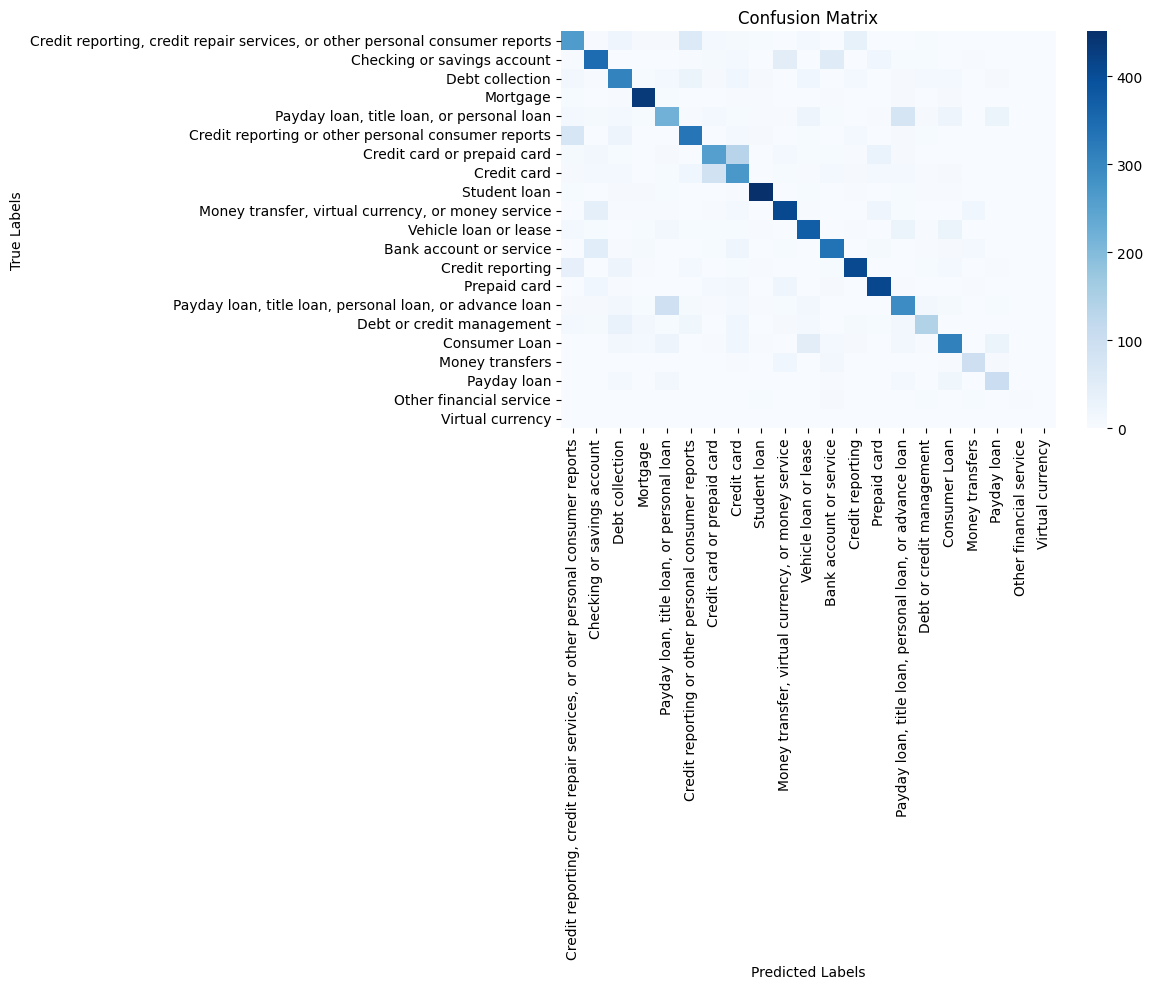

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer

# 1. Run predictions on your eval dataset
predictions = trainer.predict(dataset['validation'])

# 2. Get predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 3. Prepare label names using your id2label mapping
label_names = [id2label[i] for i in range(len(id2label))]

# 4. Print classification report
print("Classification Report:\n")
print(classification_report(labels, preds, target_names=label_names, digits=4))

# 5. Generate confusion matrix
cm = confusion_matrix(labels, preds)

# 6. Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g',
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
